In [48]:
import pandas as pd
import re
import spacy
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from spacy.tokens import DocBin
from tqdm import tqdm

In [24]:
class DataLoader:
    @staticmethod
    def load_data(path):
        return pd.read_csv(path)

In [25]:
class DataPreprocessor:
    def __init__(self, model_name: str = "en_core_web_sm"):
        # Load spaCy 
        self.nlp = spacy.load(model_name)
        disabled_pipes = [pipe for pipe in self.nlp.pipe_names if pipe not in ['tokenizer', 'tagger', 'attribute_ruler']]
        for pipe in disabled_pipes:
            self.nlp.disable_pipe(pipe)

    def preprocess_job_desc(self, text):
        # Text Preprocessing using Spacy
        text = re.sub("<[^>]+>", " ", text)  # remove html element tags
        text = re.sub("[ ]+", " ", text)  # remove long spaces
        text = re.sub("[^\u0000-\u007F]+", "", text)  # remove unicode characters/ non ASCII characters
        text = text.lower()  # transform to lower case
        text = text.strip()
        doc = self.nlp(text)
        return " ".join([word.text for word in doc])
    
    @staticmethod
    def convert_to_doc_bin(data):
        blank_nlp = spacy.blank('en')
        db = DocBin()
        for text, annotations in data:
            doc = blank_nlp(text)
            ents = []
            for start, end, label in annotations['entities']:
                span = doc.char_span(start, end, label=label)
                if type(span) is not type(None):
                    ents.append(span)
            doc.ents = ents
            db.add(doc)
        return db

# Load and Preprocess Train Data for Annotation

In [41]:
# Load data
df = DataLoader.load_data("../data/raw/linkedin_jobs_train.csv")
df = df.drop_duplicates().reset_index(drop=True)

# Preprocess Job Descriptions
texts = []
data_preprocessor = DataPreprocessor(model_name="en_core_web_sm")
for i, row in tqdm(df.iterrows()):
    texts.append(data_preprocessor.preprocess_job_desc(row['job_description'])+"\n")

# Save Jobs in form of jobs.txt
with open("../data/interim/jobs_train.txt", "w") as f:
    f.writelines(texts)

214it [00:03, 69.35it/s]


Annotate data using this link https://tecoholic.github.io/ner-annotator/

# Prepare Train, Dev and Test Data

In [27]:
# Prepare Train and Dev
# Open the annotations
with open("../data/interim/annotations.json", "r") as f:
    annotations_json = json.load(f)

# Set params for random select data
total_size = len(annotations_json['annotations'])
train_len, dev_len, test_len = int(total_size * 0.7), int(total_size * 0.15), int(total_size * 0.15) 
data = []
for aj in annotations_json['annotations']:
    data.append((aj[0], aj[1]))    

# Randomized the data
np.random.shuffle(data)

# Prepare Train Data
train_data = data[:train_len] 
db = DataPreprocessor.convert_to_doc_bin(train_data)
db.to_disk("../data/processed/train.spacy")

# Prepare Dev Data
dev_data = data[train_len : train_len + dev_len] 
db = DataPreprocessor.convert_to_doc_bin(dev_data)
db.to_disk("../data/processed/dev.spacy")

# Prepare Test Data
test_data = data[train_len + dev_len:] 
db = DataPreprocessor.convert_to_doc_bin(test_data)
db.to_disk("../data/processed/test.spacy")

In [44]:
texts = []
for data in test_data:
    texts.append(data[0])

with open("../data/interim/jobs_test.txt", "w") as f:
    f.writelines(texts)

# Train Model (From Scratch)

In [28]:
!python -m spacy init fill-config ../config/base_config.cfg ../config/config.cfg
# !python -m spacy train ../config/config.cfg --output ../models --paths.train ../data/processed/train.spacy --paths.dev ../data/processed/dev.spacy

✔ Auto-filled config with all values
✔ Saved config
..\config\config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


# Test Model

In [53]:
# Load the Test Data
with open("../data/interim/jobs_test.txt", "r") as f:
    test_data = f.readlines()

# Access the Test Data and load Spacy Model
best_model = spacy.load("../models/model-best")
i = 0
hard_skills = []
soft_skills = []
for text in test_data:
    docs = best_model(text)
    for doc in docs.ents:
        text = doc.text
        text = re.sub(" - ", "-", text)
        text = re.sub(" / ", "/", text)
        text = re.sub(" ", "_", text)
        if doc.label_ == "HARD SKILL":
            hard_skills.append(text)
        elif doc.label_ == "SOFT SKILL":
            text = re.sub("-", "_", text)
            soft_skills.append(text)

# Word Cloud 

Hard Skills

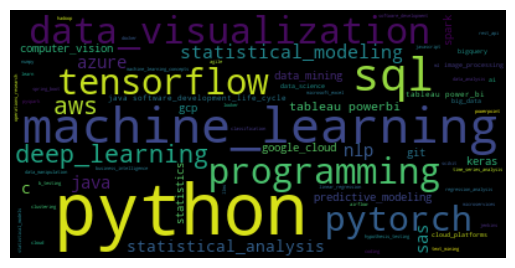

In [54]:
# join the list and lowercase all the words
text = ' '.join(hard_skills).lower()

#create the wordcloud object
wordcloud = WordCloud().generate(text)

#plot the wordcloud object
plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')
plt.show()

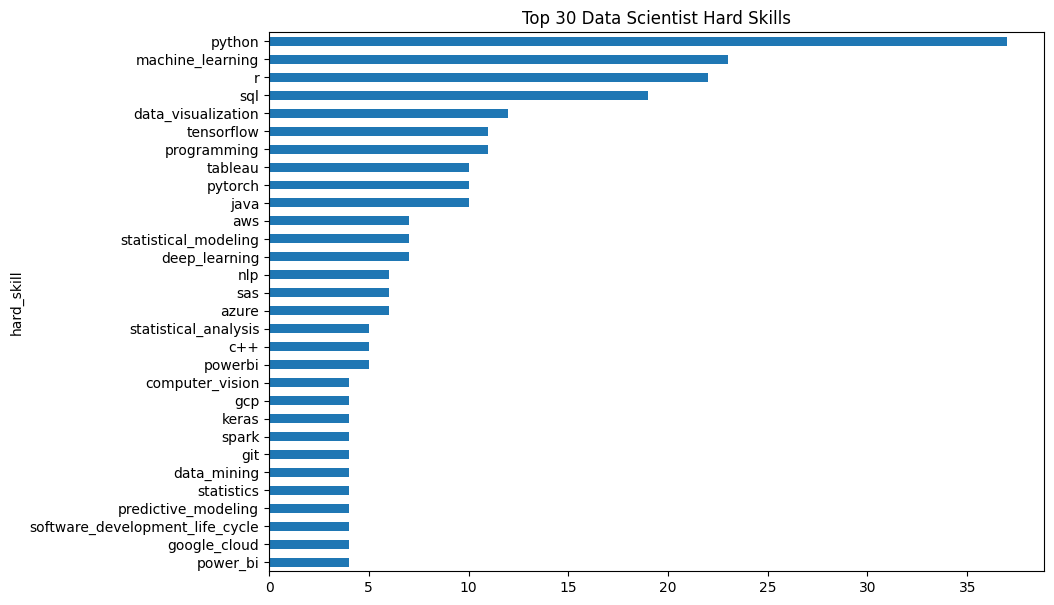

In [67]:
hard_skill_df = pd.DataFrame({
    "hard_skill": hard_skills,
})
hard_skill_df['hard_skill'].value_counts().sort_values(ascending=True)[-30:].plot(kind="barh", figsize=(10, 7), title="Top 30 Data Scientist Hard Skills")
plt.show()

Soft Skills

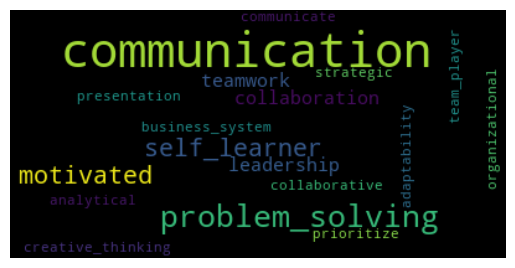

In [56]:
# join the list and lowercase all the words
text = ' '.join(soft_skills).lower()

#create the wordcloud object
wordcloud = WordCloud().generate(text)

#plot the wordcloud object
plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')
plt.show()

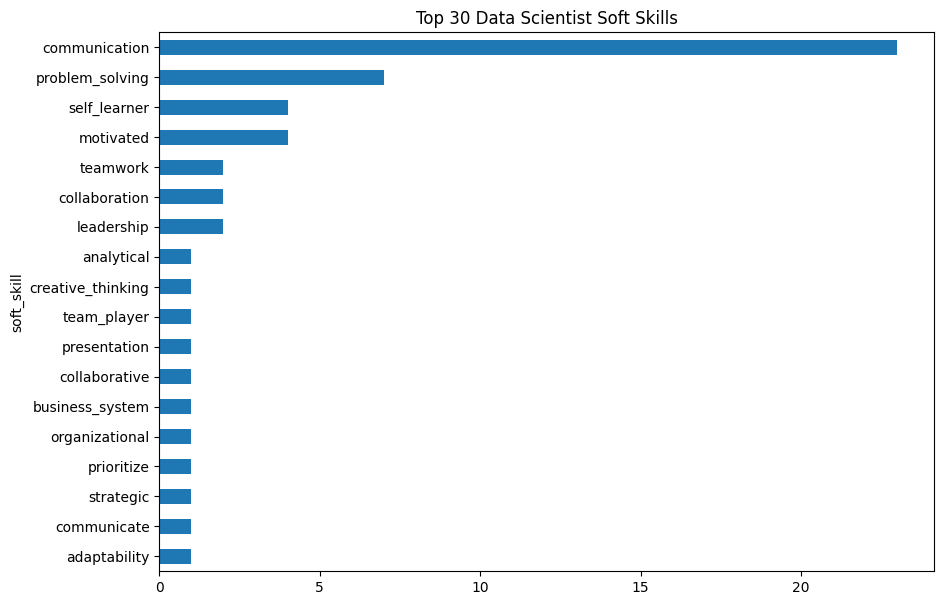

In [68]:
soft_skill_df = pd.DataFrame({
    "soft_skill": soft_skills,
})
soft_skill_df['soft_skill'].value_counts().sort_values(ascending=True)[-30:].plot(kind="barh", figsize=(10, 7), title="Top 30 Data Scientist Soft Skills")
plt.show()

In [69]:
# save data
hard_skill_df.to_csv("../reports/hard_skill.csv", index=False)
soft_skill_df.to_csv("../reports/soft_skill.csv", index=False)